We have implemented the methods to generate draws from various random variables in the file `random_numbers.py`. In this notebook, we illustrate these methods. You may want to have a look at the implementation first.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import random_numbers as rn

# Pseuso-random numbers

We illustrate here that the deterministic sequence $$x_n = a x_{n-1} \text{ mod } m$$ generates numbers that have the appearance of draws from a $U(0, 1)$ distribution.

In [2]:
nbr_of_draws = 1000000

The sequence is implemented as an iterator. Note that we need to initialize the sequence with a value. It is usually called the "seed".

In [3]:
help(rn.PseudoRandom)

Help on class PseudoRandom in module random_numbers:

class PseudoRandom(builtins.object)
 |  PseudoRandom(size, seed=90267)
 |  
 |  Class generating pseudo-random numbers using a simple
 |  procedure. It is implemented as an iterable/iterator.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, size, seed=90267)
 |      Ctor
 |      
 |      :param size: number of pseudo-random numbers to generate
 |      :type size: int
 |      
 |      :param seed: initial value of the sequence
 |      :type seed: int
 |  
 |  __iter__(self)
 |      As the object is both an iterable and an iterator, it returns
 |      itself.
 |  
 |  __next__(self)
 |      Generate the next number
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



We generate the numbers from the sequence.

In [4]:
rnd = rn.PseudoRandom(nbr_of_draws)

In [5]:
my_numbers = np.array([i for i in rnd])

If we plot the histogram, we obtain something that is very close to the pdf of a uniform distribution.

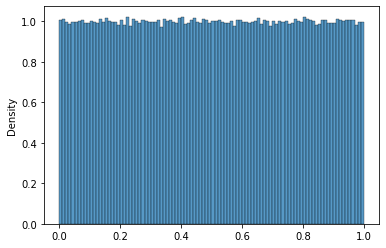

In [6]:
my_graph = sns.histplot(my_numbers, stat='density')

For the sake of comparison, we do the same with the generator of random numbers implemented into `numpy`. 

In [7]:
numpy_numbers = np.random.rand(nbr_of_draws)

We observe a similar histogram.

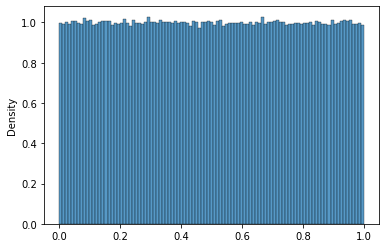

In [8]:
numpy_graph = sns.histplot(numpy_numbers, stat='density')

We can also compare the two distributions. We first need to group the two sequences in a data frame.

In [9]:
df = pd.DataFrame({'My numbers': my_numbers, 'numpy': numpy_numbers})
df

,My numbers,numpy
0,0.000042,0.571520
1,0.706463,0.966687
2,0.521522,0.488526
3,0.225619,0.222784
4,0.971458,0.374101
...,...,...
999995,0.119362,0.306122
999996,0.113760,0.271745
999997,0.968721,0.096618
999998,0.292211,0.172350


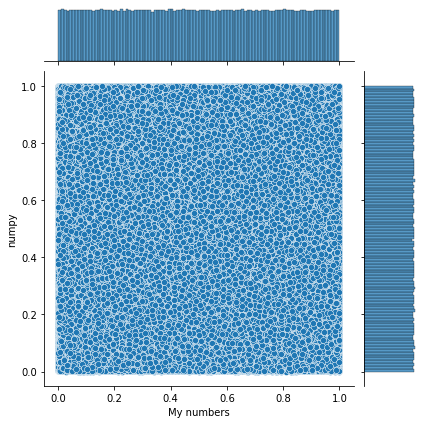

In [10]:
join_graph = sns.jointplot(data=df, x='My numbers', y='numpy')

# Discrete distributions

We consider a random variable $X$ that takes four values, with the following probabilities:
- $X=1$ with probability $0.24$,
- $X=2$ with probability $0.42$,
- $X=3$ with probability $0.11$,
- $X=4$ with probability $0.23$.

And we want to generate instances of this random variable.

In [11]:
pmf = {
    1: 0.24,
    2: 0.42,
    3: 0.11,
    4: 0.23
}

## Inverse transform method

Here is the implementation of the inverse transform method.

In [12]:
help(rn.InverseTranformDiscrete)

Help on class InverseTranformDiscrete in module random_numbers:

class InverseTranformDiscrete(builtins.object)
 |  InverseTranformDiscrete(pmf, size, seed=None)
 |  
 |  Class illustrating the simulation of discrete random variable
 |  using the inverse transform method.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, pmf, size, seed=None)
 |      Ctor
 |      
 |      :param pmf: dict where the keys are the values of the random
 |          variable and the values are the corresponding probability
 |      :type pmf: dict(int: float)
 |      
 |      :param size: number of draws to generate
 |      :type size: int
 |      
 |      :param seed: if different from None, seed used to initialize
 |         the random number generator. Default: None
 |      :type seed: int
 |      
 |      :raise ValueError: if the probabilities do not sum up to 1.0.
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data

Generation of a given number of instances

In [13]:
R = 10000
the_generator = rn.InverseTranformDiscrete(pmf, R)
the_draws = np.array([i for i in the_generator])

We plot the empirical and theoretical probability of each value

In [14]:
def compare(pmf, draws):
    R = len(draws)
    unique, counts = np.unique(draws, return_counts=True)
    freq = counts / R
    plt.plot(unique, freq, 'o')
    plt.vlines(unique, 0, freq)
    plt.ylim(bottom=0) 
    for val, prob in pmf.items():
        plt.hlines(y=prob, xmin=val-0.1, xmax=val+0.1, color='red')

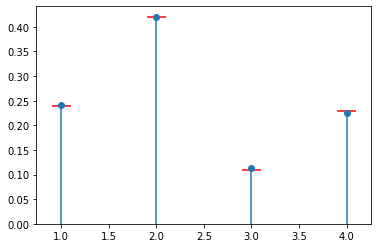

In [15]:
compare(pmf, the_draws)

## Accept-reject method

We illustrate the accept-reject method using a uniform distribution for $Y$, that is, each of the four values is associated with probability 0.25.

In [16]:
pmf_q = {
    1: 0.25,
    2: 0.25,
    3: 0.25,
    4: 0.25
}

We draw from this distribution using the inverse transform method. Note that we do not know in adance how many of them will be necessary, and several will be rejected. This is why the size is set to $+\infty$.

In [17]:
the_generator_q = rn.InverseTranformDiscrete(pmf_q, np.inf)

We calculate the values for $c_i$

In [18]:
c = [x / y for x, y in zip(pmf.values(), pmf_q.values())]
c 

[0.96, 1.68, 0.44, 0.92]

In [19]:
upper_bound = max(c)
upper_bound

1.68

In [20]:
help(rn.AcceptRejectDiscrete)

Help on class AcceptRejectDiscrete in module random_numbers:

class AcceptRejectDiscrete(builtins.object)
 |  AcceptRejectDiscrete(pmf, draw_q, size, seed=None)
 |  
 |  Class illustrating the simulation of discrete random variables
 |  using the accept-reject algorithm.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, pmf, draw_q, size, seed=None)
 |      Ctor
 |      
 |      :param pmf: dict where the keys are the values of the random
 |          variable and the values are the corresponding probability
 |      :type pmf: dict(int: float)
 |      
 |      :param draw_q: iterator that generates draws from a random
 |          variable with the same values, but different pmf. It must
 |          implement the __next__ function and must have a pmf
 |          attribute, that is a dict that associates the values with
 |          the probabilities.
 |      :type draw_q: object
 |      
 |      :param size: number of draws to generate
 |      :type size: int
 |      
 |      :param 

In [21]:
the_generator_accept_reject = rn.AcceptRejectDiscrete(
    pmf, 
    the_generator_q,
    R
)
the_draws_accept_reject = np.array(
    [i for i in the_generator_accept_reject]
)

And we compare again the empirical and theoretical values for the probabilities.

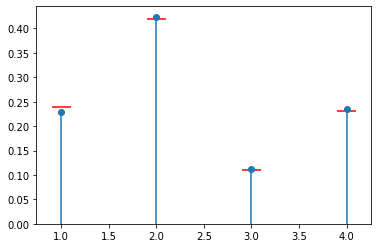

In [22]:
compare(pmf, the_draws_accept_reject)

## Numpy

For the sake of comparision, we now implement a similar object, using the function from `numpy`

In [23]:
help(rn.DiscreteFromNumpy)

Help on class DiscreteFromNumpy in module random_numbers:

class DiscreteFromNumpy(builtins.object)
 |  DiscreteFromNumpy(pmf, size, seed=None)
 |  
 |  Class illustrating the simulation of discrete random variables
 |  using the method implemented in numpy. For the sake of
 |  consistency, we give it the same structure as the other classes.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, pmf, size, seed=None)
 |      Ctor
 |      
 |      :param pmf: dict where the keys are the values of the random
 |          variable and the values are the corresponding probability
 |      :type pmf: dict(int: float)
 |      
 |      :param size: number of draws to generate
 |      :type size: int
 |      
 |      :param seed: if different from None, seed used to initialize
 |         the random number generator. Default: None
 |      :type seed: int
 |      
 |      :raise ValueError: if the probabilities do not sum up to 1.0.
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  --------

In [24]:
R = 10000
the_generator = rn.DiscreteFromNumpy(pmf, R)
the_draws = np.array([i for i in the_generator])

And we compare again the empirical and theoretical values for the probabilities.

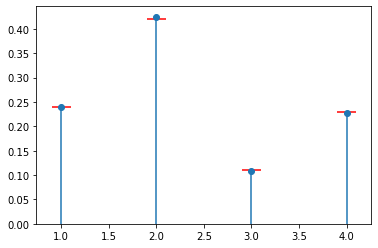

In [25]:
compare(pmf, the_draws)

# Continuous distributions

We now illustrate methods to draw from continuous random variables.

## Inverse transform method

Here is the implementation of the inverse transform method

In [26]:
help(rn.InverseTranformContinuous)

Help on class InverseTranformContinuous in module random_numbers:

class InverseTranformContinuous(builtins.object)
 |  InverseTranformContinuous(inverse_cdf, size, seed=None)
 |  
 |  Class illustrating the simulation of continuous random variables
 |  using the inverse transform method.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, inverse_cdf, size, seed=None)
 |      Ctor
 |      
 |      :param inverse_cdf: inverse of the cumulative distribution function.
 |      :type pmf: function
 |      
 |      :param size: number of draws to generate
 |      :type size: int
 |      
 |      :param seed: if different from None, seed used to initialize
 |         the random number generator. Default: None
 |      :type seed: int
 |      
 |      :raise ValueError: if the probabilities do not sum up to 1.0.
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__


We illustrate the method using the exponential distribution. We must provide the inverse function.

In [27]:
def inverse_exponential(r, b=1.0):
    return -b * np.log(r)

In [28]:
R = 10000
the_generator = rn.InverseTranformContinuous(inverse_exponential, R)
the_draws = np.array([i for i in the_generator])

We compare the empirical histogram with the pdf.

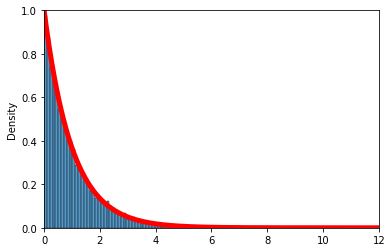

In [29]:
my_graph = sns.histplot(the_draws, stat='density')
plt.xlim(0, 12)
plt.ylim(0, 1)
X = np.arange(0, 12, 0.01)
Y = np.exp(-X)
my_graph = sns.lineplot(x=X, y=Y, lw=5, color='red')

We can do the same with the numpy function.

In [30]:
numpy_draws = np.random.exponential(scale=1.0, size=R)

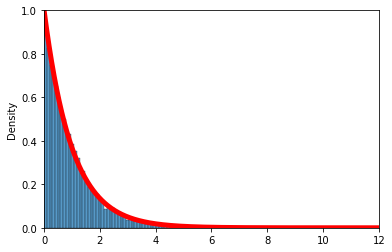

In [31]:
my_graph = sns.histplot(numpy_draws, stat='density')
plt.xlim(0, 12)
plt.ylim(0, 1)
my_graph = sns.lineplot(x=X, y=Y, lw=5, color='red')

## Accept-reject method


We now illustrate the accept-rehect method, using the example from the lecture.

In [32]:
help(rn.AcceptRejectContinuous)

Help on class AcceptRejectContinuous in module random_numbers:

class AcceptRejectContinuous(builtins.object)
 |  AcceptRejectContinuous(pdf, draw_q, upper_bound, size, seed=None)
 |  
 |  Class illustrating the simulation of continuous random variables
 |  using the accept-reject algorithm.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, pdf, draw_q, upper_bound, size, seed=None)
 |      Ctor
 |      
 |      :param pdf: probability density function of the target distribution
 |      :type pdf: fct
 |      
 |      :param draw_q: iterator that generates draws from an auxiliary
 |          random variable with different pdf. It must implement the
 |          __next__ function and must have a pdf attribute, that is
 |          the probability density function of the random variable.
 |      :type draw_q: object
 |      
 |      :param upper_bound: constant c such that the ratio between the
 |          pdf of the target distribution and the auxiliary distribution
 |          is al

The target random variable is $X=|\bar{X}|$, where $\bar{X}\sim N(0,1).$

In [33]:
def target_pdf(x):
    return 2 * np.exp(-x * x / 2) / np.sqrt(2 * np.pi)

We define the auxiliary distribution. Here, an exponential distribution with parameter 1, as in the lecture.

In [34]:
def auxiliary_pdf(x):
    return np.exp(-x)

We define the object that is used by the generator. It must create draws from the auxiliary distribution, and calculate the pdf.

In [35]:
class exponential:
    def __init__(self):
        self.pdf = auxiliary_pdf
    
    def __next__(self):
        r = np.random.rand()
        return -np.log(r)

In [36]:
auxiliary = exponential()

The upper bound has been calculated in the lecture: $c=\sqrt{2 e / \pi}$.

In [37]:
upper_bound = np.sqrt(2 * np.e / np.pi)

We can now generate the draws.

In [38]:
R = 100000
the_generator_accept_reject = rn.AcceptRejectContinuous(
    target_pdf, 
    auxiliary,
    upper_bound,
    R
)
the_draws_accept_reject = np.array(
    [i for i in the_generator_accept_reject]
)

We compare the empirical histogram with the pdf.

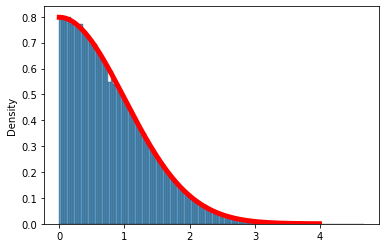

In [39]:
my_graph = sns.histplot(the_draws_accept_reject, stat='density')
X = np.arange(0, 4, 0.01)
Y = target_pdf(X)
my_graph = sns.lineplot(x=X, y=Y, lw=5, color='red')

As described in the lecture, we now randomly assign the sign to obtain draws from a normal distribution

In [40]:
def the_sign(x):
    r = np.random.rand()
    if r < 0.5:
        return -x
    return x

In [41]:
normal_draws = [the_sign(x) for x in the_draws_accept_reject]

And we compare the empirical histogram with the pdf.

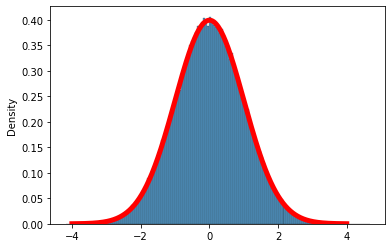

In [42]:
my_graph = sns.histplot(normal_draws, stat='density')
X = np.arange(-4, 4, 0.01)
Y = stats.norm.pdf(X)
my_graph = sns.lineplot(x=X, y=Y, lw=5, color='red')

# Multivariate normal

We now illustrate how to generate draws from a multivariate  normal
 distributions, combining independent draws and the Cholesky factor
 for the variance-covariance matrix.  

In [43]:
help(rn.MultivariateNormal)

Help on class MultivariateNormal in module random_numbers:

class MultivariateNormal(builtins.object)
 |  MultivariateNormal(mu, sigma, size, seed=None)
 |  
 |  Class illustrating the generation of draws from multivariate normal
 |  distributions, combining independent draws and the Cholesky factor
 |  for the variance-covariance matrix.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, mu, sigma, size, seed=None)
 |      Ctor
 |      
 |      :param mu: location vector
 |      :type mu: numpy.array, dimension nx1
 |      
 |      :param sigma: variance-covariance matrix. Must be positive semi-definite.
 |      :type sigma: numpy.array dimension nxn
 |      
 |      :param size: number of draws to generate
 |      :type size: int
 |      
 |      :param seed: if different from None, seed used to initialize
 |         the random number generator. Default: None
 |      :type seed: int
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  -----------------------------------------

## Independent normals

We first use the method with the identity matrix, so that the draws are independent.

In [44]:
mu = np.array([3, 4])
identity_matrix = np.array([[1, 0], [0, 1]])

In [45]:
R = 10000
mv_normal_generator = rn.MultivariateNormal(mu, identity_matrix, R)
the_draws_mv_normal = np.array([i for i in mv_normal_generator])

We organize the drws in a data frame in order to plot them jointly.

In [46]:
df = pd.DataFrame(the_draws_mv_normal, columns=['X', 'Y'])

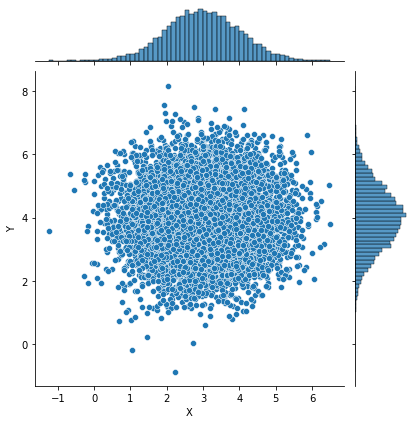

In [47]:
join_graph = sns.jointplot(data=df, x='X', y='Y')

We now perform the same tasks with correlated draws.

In [48]:
A = np.array([[1, 0.9], [0.9, 1]])
A

array([[1. , 0.9],
       [0.9, 1. ]])

In [49]:
mv_normal_generator = rn.MultivariateNormal(mu, A, R)
the_draws_mv_normal = np.array([i for i in mv_normal_generator])

In [50]:
df = pd.DataFrame(the_draws_mv_normal, columns=['X', 'Y'])

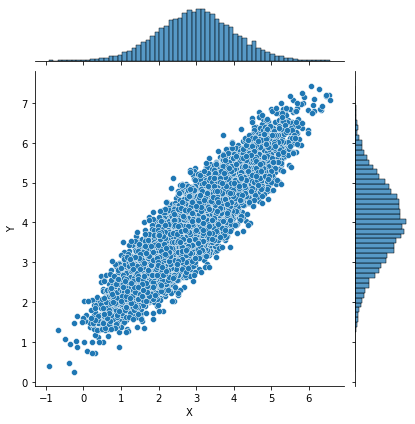

In [51]:
join_graph = sns.jointplot(data=df, x='X', y='Y')

## Using numpy

And we show how to do the same using the `numpy` function.

In [52]:
numpy_draws = np.random.multivariate_normal(mean=mu, cov=A, size=R)

In [53]:
df = pd.DataFrame(numpy_draws, columns=['X', 'Y'])

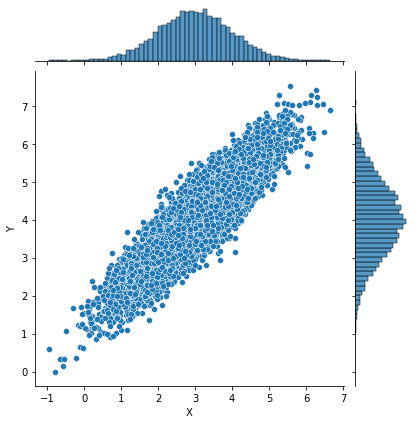

In [54]:
join_graph = sns.jointplot(data=df, x='X', y='Y')